# Import Packages

In [1]:
# data cleaning and wrangling tools
import pandas as pd
import ast
import re
import string

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
from pprint import pprint

# nlp tools
import spacy
import nltk
nltk.download('stopwords')
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Enable logging for gensim to keep track of the training process
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# save files
import pickle

# disable warnings that bring up a deprecation warning
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [0]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [0]:
# create function to further clean each ingredient string
def clean_ingredients(ingredient):
    if ingredient != None:
        cleaned = ingredient.lower()
        cleaned = ingredient.replace("uncategorized", "")
        
        parsed = re.sub("(\d?)", "", cleaned)
        return parsed

In [0]:
# define function to pick model after it is fit
def pickle_model(model_name, model):
    model_pickle_path = './foodnetwork_{}.pkl'.format(model_name)
    model_pickle = open(model_pickle_path, 'wb')
    pickle.dump(model, model_pickle)
    model_pickle.close()

# Import Data

In [0]:
# read in pickled data for topic modeling ingredients
ingredients_grouped = pd.read_pickle("foodnetwork_ingred_grp_sklearn.pkl")

In [6]:
ingredients_grouped.head()

,ingredients,ingredient_parsed
recipe_id,,
1,"1 loaf French bread (13 to 16 ounces), 8 large...",french_bread eggs half_half milk granulated_su...
2,"1 (14-ounce) can sweetened condensed milk, 1 (...",sweetened_condensed_milk frozen_whipped_toppin...
3,"1 (18 1/4-ounce) package yellow cake mix, 1 eg...",yellow_cake_mix egg butter_melted cream_cheese...
4,"1 (15 1/4-ounce) can whole kernel corn, draine...",whole_kernel_corn_drained cream_style_corn cor...
5,"4 skinless chicken breast halves, with ribs, 2...",skinles_chicken_breast_ribs skinles_chicken_th...


In [7]:
ingredients_grouped.shape

(6652, 2)

In [8]:
ingredients_grouped.isnull().sum()

ingredients          0
ingredient_parsed    0
dtype: int64

# Grid Search with Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF) Using Scikit-Learn

## Grid Search to Find Best Parameters

In [9]:
# read in model pickles

# sklearn nmf model
tfidf_pickle = open('./foodnetwork_tfidf_sklearn.pkl', 'rb')
tfidf = pickle.load(tfidf_pickle)
print("NMF Base Model:")
print(tfidf)

print(" ")

# sklearn lda model
tf_pickle = open('./foodnetwork_tf_sklearn.pkl', 'rb')
tf = pickle.load(tf_pickle)
print("LDA Base Model:")
print(tf)

NMF Base Model:
  (0, 353)	0.3134522248605731
  (0, 303)	0.1673596106963335
  (0, 475)	0.2563049930141449
  (0, 578)	0.19621983472316568
  (0, 443)	0.2248052838425254
  (0, 926)	0.21812469016654423
  (0, 166)	0.3547109646172703
  (0, 592)	0.4529356786024528
  (0, 568)	0.27608706304814423
  (0, 91)	0.16225576084894824
  (0, 543)	0.20985747818384243
  (0, 644)	0.3017961784778537
  (0, 545)	0.3206017844234084
  (1, 578)	0.345668161678009
  (1, 873)	0.5316553770574135
  (1, 38)	0.5694541785138828
  (1, 211)	0.5230468627390515
  (2, 303)	0.20420609880906992
  (2, 166)	0.21640269712602073
  (2, 592)	0.27632780559781717
  (2, 211)	0.3622781811849203
  (2, 289)	0.2581185510092514
  (2, 95)	0.6336142162944243
  (2, 923)	0.3519603143998471
  (2, 683)	0.3345130502665819
  :	:
  (6647, 210)	0.3766087490154594
  (6647, 96)	0.4214079968084271
  (6647, 816)	0.49361197744246843
  (6647, 616)	0.4662623303776297
  (6648, 303)	0.37213565620096734
  (6648, 61)	0.20789498387891447
  (6648, 594)	0.225700856

In [0]:
# Define Search Parameters
search_params = {'n_components': [10, 15, 20, 25, 30, 40, 50, 60, 70], 'learning_decay': [.5, .7, .9]}

In [0]:
# Init the Model
lda = LatentDirichletAllocation()

In [0]:
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

In [0]:
# Do the Grid Search
lda_gs = model.fit(tf)

In [0]:
# Best Model
best_lda_model = model.best_estimator_

In [0]:
# # Pickle Best Model
# pickle_model("tf_sklearn_best", best_lda_model)

In [15]:
# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}


In [16]:
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Log Likelihood Score:  -114343.56651430561
Model Perplexity:  347.39322921184487


In [17]:
model.cv_results_["params"]

[{'learning_decay': 0.5, 'n_components': 10},
 {'learning_decay': 0.5, 'n_components': 15},
 {'learning_decay': 0.5, 'n_components': 20},
 {'learning_decay': 0.5, 'n_components': 25},
 {'learning_decay': 0.5, 'n_components': 30},
 {'learning_decay': 0.5, 'n_components': 40},
 {'learning_decay': 0.5, 'n_components': 50},
 {'learning_decay': 0.5, 'n_components': 60},
 {'learning_decay': 0.5, 'n_components': 70},
 {'learning_decay': 0.7, 'n_components': 10},
 {'learning_decay': 0.7, 'n_components': 15},
 {'learning_decay': 0.7, 'n_components': 20},
 {'learning_decay': 0.7, 'n_components': 25},
 {'learning_decay': 0.7, 'n_components': 30},
 {'learning_decay': 0.7, 'n_components': 40},
 {'learning_decay': 0.7, 'n_components': 50},
 {'learning_decay': 0.7, 'n_components': 60},
 {'learning_decay': 0.7, 'n_components': 70},
 {'learning_decay': 0.9, 'n_components': 10},
 {'learning_decay': 0.9, 'n_components': 15},
 {'learning_decay': 0.9, 'n_components': 20},
 {'learning_decay': 0.9, 'n_compon

In [18]:
len(model.cv_results_["params"])

27

In [19]:
len(model.cv_results_["mean_test_score"])

27

In [20]:
model.cv_results_["mean_test_score"]

array([-114678.91788443, -117793.74825839, -119889.10041757,
       -122288.64026318, -124163.83408404, -127126.84806455,
       -130033.66286433, -132723.02685278, -134755.47411007,
       -114556.97225408, -117415.3937916 , -119923.66427084,
       -122476.26271439, -123793.20747518, -127688.4784308 ,
       -130391.33795276, -132490.16659416, -134752.45400688,
       -114343.56651431, -117477.16535257, -120358.6169253 ,
       -121835.98292888, -124085.92633913, -127473.88509492,
       -130066.75922649, -132345.23125787, -134827.23266693])

## Analysis of the Results

In [21]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf)

# column names
topicnames = ["Topic" + str(i+1) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Recipe_" + str(i+1) for i in range(len(ingredients_grouped))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,dominant_topic
Recipe_1,0.01,0.01,0.26,0.01,0.01,0.01,0.18,0.52,0.01,0.01,7
Recipe_2,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.82,0.02,0.02,7
Recipe_3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.91,0.01,0.01,7
Recipe_4,0.03,0.03,0.77,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
Recipe_5,0.01,0.01,0.01,0.01,0.62,0.01,0.01,0.01,0.33,0.01,4
Recipe_6,0.01,0.01,0.01,0.01,0.21,0.01,0.01,0.01,0.4,0.3,8
Recipe_7,0.01,0.01,0.33,0.01,0.01,0.01,0.01,0.6,0.01,0.01,7
Recipe_8,0.01,0.01,0.26,0.01,0.01,0.01,0.46,0.23,0.01,0.01,6
Recipe_9,0.01,0.83,0.1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Recipe_10,0.01,0.01,0.77,0.01,0.01,0.01,0.01,0.15,0.01,0.01,2


In [22]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,879
1,9,873
2,1,841
3,0,708
4,5,691
5,7,637
6,6,626
7,3,478
8,8,471
9,2,448


In [0]:
# pyLDAvis.enable_notebook()
# panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
# panel

In [0]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

In [26]:
df_topic_keywords.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.100001,0.100001,0.100008,0.100013,0.100000,0.100009,0.100001,0.100033,0.100022,0.100018,0.100000,0.100005,0.104546,0.100004,0.100002,2.391024,0.100003,3.099920,0.100020,6.069360,1.099885,11.621272,8.980075,1.904823,3.897924,0.100000,0.100027,0.100004,0.100000,5.448999,0.100001,0.198536,0.100002,0.100006,6.897804,0.100002,0.100006,16.608048,1.162200,0.100033,...,43.537297,20.727461,0.100054,0.100009,0.100022,2.142037,0.100040,16.316379,14.222163,0.100010,0.100001,0.100024,0.100001,0.100015,0.100007,0.100055,0.100058,0.100003,0.100001,0.100000,0.100007,0.655977,0.100000,1.222952,0.100025,0.100000,0.100007,0.100000,0.100004,0.100000,11.855071,0.100001,0.100000,1.099918,0.100019,0.100000,0.100005,0.100005,0.100004,0.100000
1,0.100005,0.100021,123.376818,13.796891,0.100000,0.100001,0.100010,22.205832,17.879909,0.100007,0.100019,33.537047,4.911473,0.100001,9.134589,52.098474,0.100002,0.100014,0.475314,21.593187,0.100009,1.107248,0.100000,0.100007,0.100003,0.100003,0.100001,9.422537,0.100000,0.100015,0.100017,4.781642,0.100003,0.100001,0.100002,0.100007,0.100003,0.100014,0.100002,0.100000,...,12.021764,0.100000,13.099916,1.136303,0.100002,0.100002,2.646471,8.329201,6.311114,22.920314,0.100017,3.363638,0.721974,0.100011,0.100015,0.100013,0.100000,0.100010,0.100003,0.100001,0.100000,0.100009,0.100009,0.100008,67.721668,0.100003,1.663030,0.100004,0.100003,14.441909,0.100020,11.697735,0.100025,0.100018,14.653973,0.100020,0.100008,1.495448,3.234583,0.100000
2,27.099949,0.100001,14.725360,0.100018,0.100009,6.636819,0.100011,0.100008,0.100007,0.100008,0.100012,20.447061,8.706488,0.100000,2.065390,0.100010,0.100004,2.656304,7.181902,0.100004,0.100001,0.100006,0.100001,0.100006,0.100036,0.100006,0.100000,0.100002,0.100000,0.100002,0.100000,0.100006,0.100001,0.100011,0.100000,0.751706,0.324840,0.100009,10.437369,0.100008,...,1.582223,0.100001,0.100000,0.100003,0.100035,0.100000,7.001691,0.100010,0.100004,0.100015,9.099964,36.930683,76.478008,0.100070,9.510658,0.100010,0.100074,0.100008,20.401767,0.100026,2.099970,11.543993,0.100008,0.100000,0.100006,0.100000,0.100002,0.100000,0.100003,0.100010,8.514619,0.100010,4.256256,0.100019,0.100015,0.100000,2.133988,0.100000,0.100009,0.100000
3,0.100009,0.100003,9.465937,2.403033,0.100000,0.100025,0.100007,0.707462,7.491128,7.039504,14.099948,4.786495,0.100004,0.100003,0.100000,19.692879,24.099958,0.100004,0.100005,0.100005,0.100022,0.100062,0.100008,0.100002,0.100071,0.100001,0.100000,8.328842,0.100001,11.221634,13.325693,3.909442,8.929528,8.629375,0.100000,0.100007,0.100002,0.100012,0.100002,0.100003,...,2.573044,0.100001,0.100000,9.853733,0.100000,0.100001,0.100007,28.468008,16.421486,0.100013,0.100000,0.100007,0.100003,10.770606,0.100012,0.100015,0.100003,0.100027,8.141259,0.100000,0.100008,0.100000,0.100000,0.100000,10.348755,0.100002,0.100011,0.100003,0.100006,5.543017,0.135989,2.200177,2.099882,0.100046,5.380982,0.100000,0.100003,0.100000,0.100012,0.100010
4,0.100000,6.005018,1.052099,0.100015,0.100001,2.193005,0.100004,13.136445,0.100003,2.160461,0.100003,1.695586,0.100015,3.801223,0.100000,147.550037,0.100013,29.426173,6.149866,0.100012,20.591638,0.100005,0.100001,15.119366,0.100001,0.100001,0.100001,0.100003,0.100003,4.275145,4.134536,0.100002,0.100029,9.570579,0.100000,0.100003,0.100004,13.827627,0.100018,0.100001,...,0.100013,0.100000,0.100000,12.750328,0.100000,0.100001,2.651703,0.123630,24.273226,21.141667,0.100014,19.004707,0.100005,3.099941,3.689292,0.100000,0.100000,3.408982,0.100011,0.100030,0.100018,0.100012,0.100001,0.100021,0.100012,0.100009,10.536910,0.100010,0.100003,0.100005,78.322357,2.685814,10.943787,8.099993,0.165952,2.723799,2.716744,0.100015,3.494658,4.983805


In [0]:
# define number of max features
no_features = 1000

# define documents to vectorize
documents = ingredients_grouped.ingredient_parsed

# Instantiate vectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [28]:
# Assign Column and Index
df_topic_keywords.columns = tf_feature_names
df_topic_keywords.index = topicnames

# Styling
def color_red(val):
    color = 'red' if val > 1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold_red(val):
    weight = 700 if val > 1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# View
df_topic_keywords = df_topic_keywords.style.applymap(color_red).applymap(make_bold_red)
df_topic_keywords

In [35]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
      keywords = np.array(vectorizer.get_feature_names())
      topic_keywords = []
      for topic_weights in lda_model.components_:
          top_keyword_locs = (-topic_weights).argsort()[:n_words]
          topic_keywords.append(keywords.take(top_keyword_locs))
      return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,garlic,fish_sauce,sugar,canola,ginger,coconut_milk,soy_sauce,black_pepper_taste,lime_juiced,fresh_lime_juice,scallions,rice_wine_vinegar,chicken_stock,peanut,black_pepper
Topic 1,black_pepper,cumin,garlic,vegetable,coriander,garlic_powder,turmeric,chili_powder,cayenne_pepper,canola,paprika,cinnamon,allspice,olive,garam_masala
Topic 2,sugar,cinnamon,butter,whole_cloves,light_brown_sugar,brown_sugar,unsalted_butter,vegetable,dark_rum,ice,innamon,heavy_cream,cold,raisins,sour_cream
Topic 3,black_pepper,mayonnaise,butter,garlic,olive,sour_cream,purpose_flour,cayenne_pepper,lemon_juiced,onion,parsley_leaves,chicken_stock,coarse_black_pepper,cumin,lemon_juice
Topic 4,olive,black_pepper,garlic,onion,arlic_clove,tomato_paste,dry_white_wine,red_wine_vinegar,yellow_onion,bay_leaves,taste,dried_oregano,fresh_thyme,fresh_flat_leaf_parsley,grated_parmesan
Topic 5,pepper,olive,garlic,garlic_finely,butter,black_pepper,chicken_stock,unsalted_butter,honey,white_wine,shallot,heavy_cream,red_wine_vinegar,onion,sherry_vinegar
Topic 6,black_pepper,olive,eggs,heavy_cream,dijon_mustard,unsalted_butter,grated_parmesan,garlic,squeezed_lemon_juice,purpose_flour,mayonnaise,butter,fresh_parsley_leaves,worcestershire_sauce,panko
Topic 7,purpose_flour,sugar,eggs,milk,baking_powder,unsalted_butter,egg,granulated_sugar,vanilla_extract,baking_soda,cinnamon,flour,pure_vanilla_extract,heavy_cream,whole_milk
Topic 8,black_pepper,olive,lemon_juiced,garlic,fresh_lemon_juice,olive_drizzling,fresh_basil_leaves,lemon,dried_oregano,seasoning,garlic_peeled,grated_parmesan,cumin,red_wine_vinegar,capers
Topic 9,soy_sauce,sugar,garlic,sesame,vegetable,rice_vinegar,honey,cornstarch,black_pepper,toasted_sesame,rice_wine_vinegar,low_sodium_soy_sauce,scallion,peanut,canola


## Clustering Documents with Similar Topics and Visualization

In [36]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.27  0.38  0.2   0.21  0.45  0.34  0.27  0.27  0.21  0.44]
 [ 0.11 -0.18 -0.04 -0.05 -0.44 -0.17 -0.11 -0.06 -0.06  0.84]]
Perc of Variance Explained: 
 [0.01 0.17]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

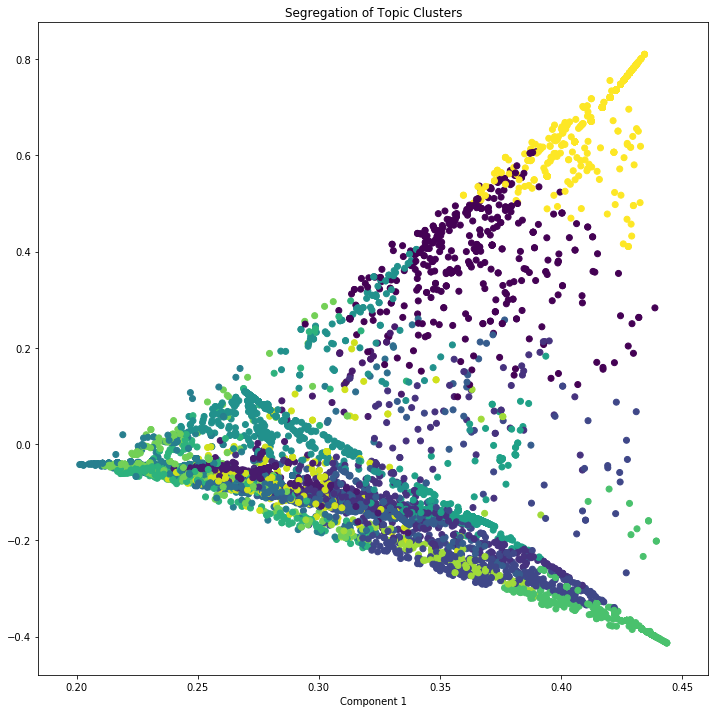

In [37]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# Obtaining Similar Documents For Any Given Piece of Text

In [41]:
ingredients_grouped.head()

,ingredients,ingredient_parsed
recipe_id,,
1,"1 loaf French bread (13 to 16 ounces), 8 large...",french_bread eggs half_half milk granulated_su...
2,"1 (14-ounce) can sweetened condensed milk, 1 (...",sweetened_condensed_milk frozen_whipped_toppin...
3,"1 (18 1/4-ounce) package yellow cake mix, 1 eg...",yellow_cake_mix egg butter_melted cream_cheese...
4,"1 (15 1/4-ounce) can whole kernel corn, draine...",whole_kernel_corn_drained cream_style_corn cor...
5,"4 skinless chicken breast halves, with ribs, 2...",skinles_chicken_breast_ribs skinles_chicken_th...


In [45]:
ingredients_grouped.ingredients[1]

'1 loaf French bread (13 to 16 ounces), 8 large eggs, 2 cups half-and-half, 1 cup milk, 2 tablespoons granulated sugar, 1 teaspoon vanilla extract, 1/4 teaspoon ground cinnamon, 1/4 teaspoon ground nutmeg, Dash salt, Praline Topping, recipe follows, Maple syrup, 1/2 pound (2 sticks) butter, 1 cup packed light brown sugar, 1 cup chopped pecans, 2 tablespoons light corn syrup, 1/2 teaspoon ground cinnamon, 1/2 teaspoon ground nutmeg'